# Diamonds modeling

A model can not only be used to predict a value, as we did in the MPG-dataset, it can also be used to get rid of a certain relationship in our data to help us see another relationship.

For example: when working with diamonds, the size is a big factor in the cost. But diamonds have a cut as well [link](https://www.diamondcuts.com/) and that cut also has a relation with the price of the diamond. But it doesn't look that way when we look at the box plots.

In [1]:
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../files/diamonds.csv", index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


<Axes: xlabel='cut', ylabel='price'>

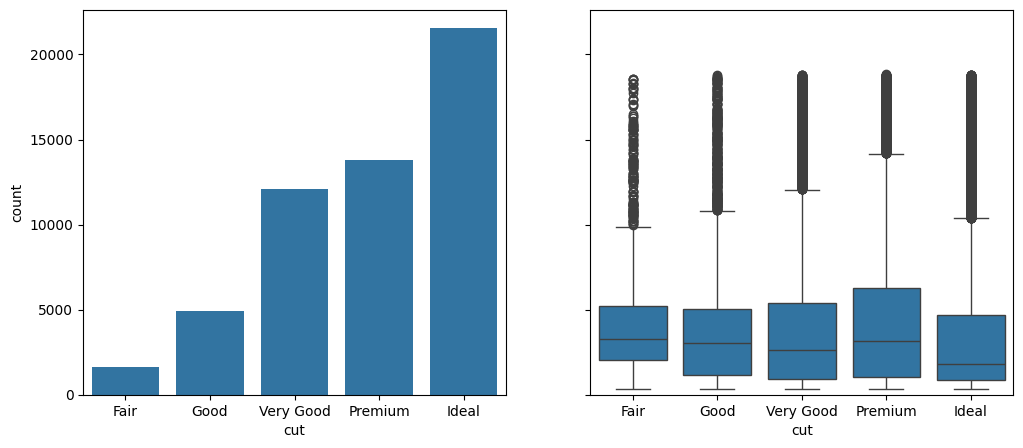

In [3]:
from pandas.api.types import CategoricalDtype

cut_type = CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)
df["cut"] = df['cut'].astype(cut_type)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.countplot(x="cut", data=df, ax = ax1)
sns.boxplot(data=df, x='cut', y='price', ax = ax2)

It's mainly the boxplots that are baffling: why are fair-cut diamonds the more expensive kind? Ideally cut diamonds are even the cheapest kind! And it's not a not-enough-data-problem, as even for fair cut diamonds there are more than 1000 rows in the dataset.

So we add some domain knowledge: **Weight is important factor in price.** Let’s try to separate out the effect of carat on the price.

(The graph below is interesting: why is the alpha set to 0.1? What does this mean for the dark areas?)

<Axes: xlabel='carat', ylabel='price'>

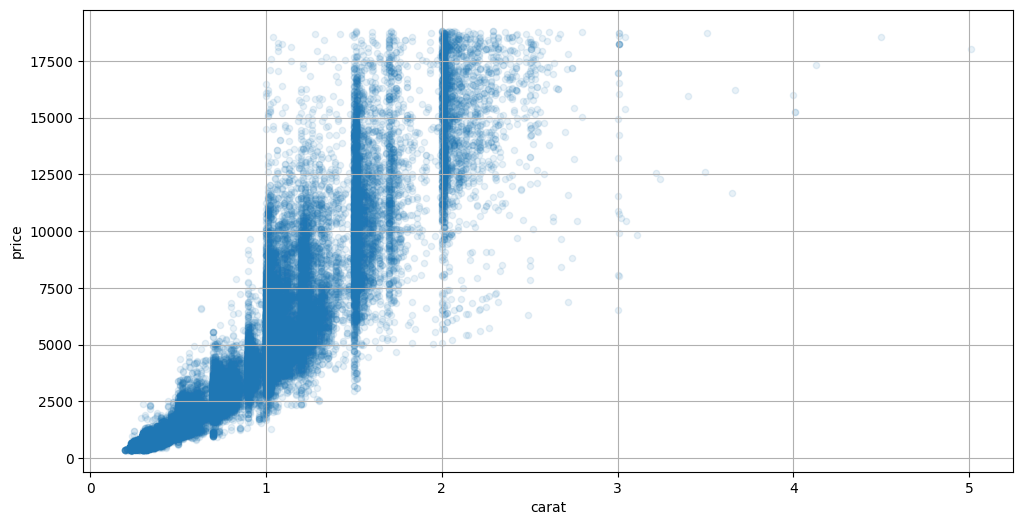

In [4]:
df.plot(kind='scatter', x="carat", y="price", grid=True,fontsize=10, figsize=(12, 6), alpha=0.1)

Price vs carat has a an exponential relationship, meaning the price will rise by the _squared_ weight of the diamond. If you want to transform an exponential relationship into a linear one, you need to use a log-transformation.

Let's recalculate the price value into a linear column.

<Axes: xlabel='log_carat', ylabel='log_price'>

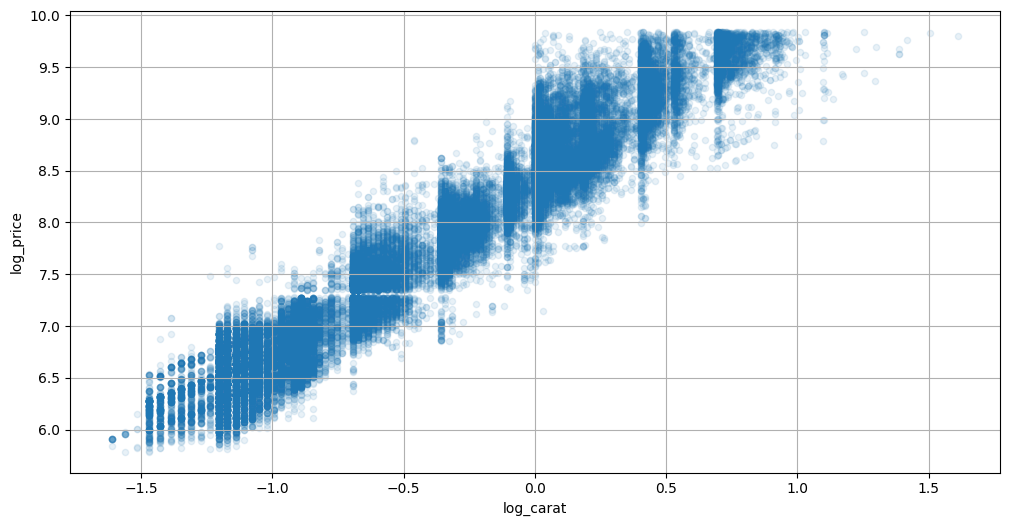

In [5]:
df["log_price"] = np.log(df["price"])
df["log_carat"] = np.log(df["carat"])
# df.head()
df.plot(kind='scatter', x="log_carat", y="log_price", grid=True,fontsize=10, figsize=(12, 6), alpha=0.1)

Nice and linear. Do remember that you can't use the log_price and log_carat columns to find an actual price or weight. The unit is al wrong (it's in log_of_dollar and log_of_carat, which has no physical meaning).

Next step is creating a model.

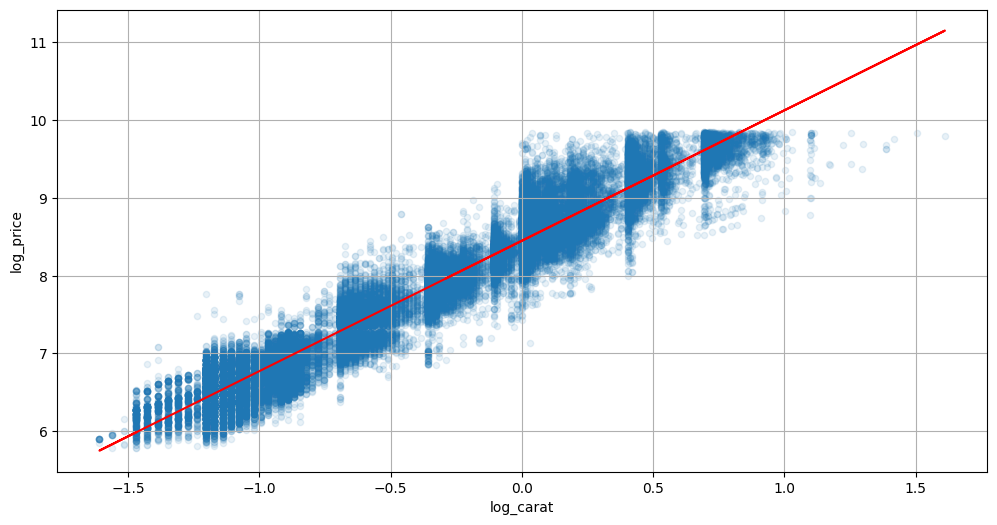

In [6]:
from sklearn import datasets, linear_model

x = df.log_carat.values.reshape(-1, 1)
y = df.log_price.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
model = regr.fit(x, y)

fig, ax = plt.subplots(figsize=(12,6))

df.plot(kind='scatter', x="log_carat", y="log_price", grid=True,fontsize=10, ax=ax,  figsize=(12, 6), alpha=0.1)
plt.plot(x, regr.predict(x), color='red')

In [7]:
print(f"a= {model.coef_[0][0]}, b= {model.intercept_[0]}")

a= 1.6758167307249736, b= 8.44866072802682


And there is our linear model. Now we use this to predict the values for every weight. Once we have this predicted weight, we use it to calculate the residuals (or the error) for every actual value.

<Axes: xlabel='log_carat', ylabel='log_price_residuals'>

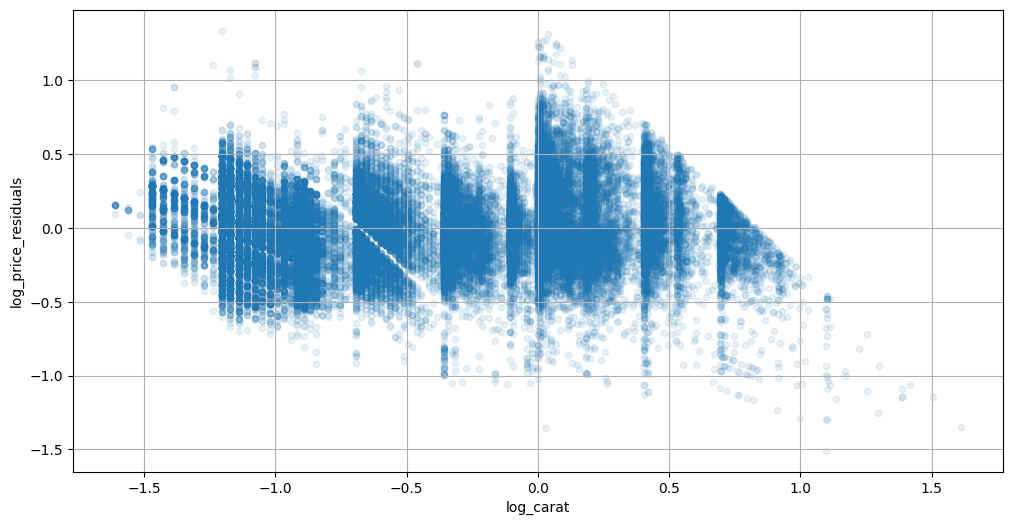

In [8]:
df['log_price_predicted'] = model.predict(df.log_carat.values.reshape(-1, 1))
df['log_price_residuals'] = df['log_price'] - df['log_price_predicted']

# df.head()
df.plot(kind='scatter', x="log_carat", y="log_price_residuals", grid=True,fontsize=10, figsize=(12, 6), alpha=0.1)

And there we have it, a graph showing the relationship between the price and the weight (in carat) of a diamond without the strong linear relationship between these two variables. And that means we can draw the graph showing the relationship between the price and the cut and not be bothered by the weight!

<Axes: xlabel='cut', ylabel='log_price_residuals'>

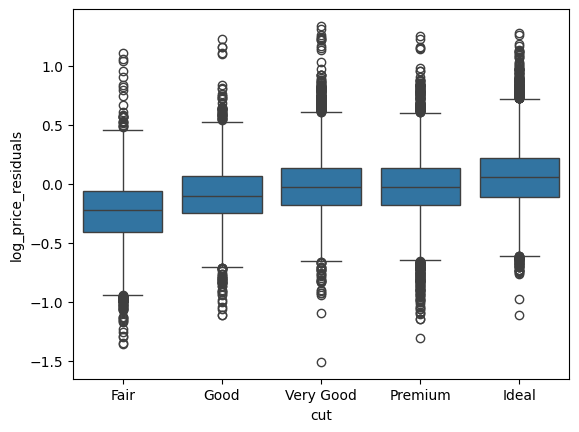

In [9]:
sns.boxplot(data=df, x='cut', y='log_price_residuals')

See the mean going up as the cut increases? That was what we needed.

As for the unit of the Y-axis: it's the difference between the log_price and the predicted log_price. It has no monetary value, but is a good indication.